In [1]:
'''Analysis of KL divergence between an MoG and a univariate Gaussian

 ...
 
'''


paper_width_cm = 15
paper_width_inch = paper_width_cm / 2.54

import matplotlib
from matplotlib import rc
# Axes3D import has side effects, it enables using projection='3d' in add_subplot
rc('font',**{'family':'serif','serif':['Computer Modern Roman']})
rc('text', usetex=True)
rc('text.latex', preamble=r'\usepackage{amsmath}')
from mpl_toolkits.mplot3d import Axes3D  

import matplotlib.pyplot as plt
from matplotlib import cm
import random
import numpy as np

from tensorflow.keras.layers import Input, Dense, Lambda, Layer
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras import metrics
import vae_tools.metrics

import tensorflow.keras as keras
import tensorflow as tf
from scipy.optimize import fmin
from scipy.stats import entropy
from scipy.spatial.distance import jensenshannon
from scipy.stats import norm
import sys


# show the network
from IPython.display import SVG
from tensorflow.keras.utils import model_to_dot


In [2]:
# Definition of functions

def dkl_gauss(mu1, std1, mu2, std2):
    # DKL(N(mu1, std1)||N(mu2, std2)) i.e. DKL(p||q)
    # where p is the ground truth and q is the approximator
    return np.log(std2) - np.log(std1) + std1**2 / (2 * std2**2) + (mu1 - mu2)**2 / (2 * std2**2) - 1/2

def dkl_gauss_opt(mu_std, mu1, std1, q_is_p = False):
    # special function for optimization
    # returns DKL(N(mu_std)||N(mu1, std1))
    if q_is_p:
        return dkl_gauss(mu1, std1, mu_std[0], mu_std[1])
    else:
        return dkl_gauss(mu_std[0], mu_std[1], mu1, std1)

def dkl_gauss_mog_sum(mu1_std1, mu2_std2, q_is_p = False):
    # returns the naive sum between a univariate gaussian and an MoG
    # DKL(N(mu_std)||N(mu1, std1)) + DKL(N(mu_std)||N(mu2, std2)) + ...
    r = 0
    if q_is_p:
        for mu_std in mu2_std2:
            r += dkl_gauss(mu1_std1[0], mu1_std1[1], mu_std[0], mu_std[1])
    else:
        for mu_std in mu2_std2:
            r += dkl_gauss(mu_std[0], mu_std[1], mu1_std1[0], mu1_std1[1])
    return r / np.float(len(mu_std))

def dkl_gauss_opt2(mu_std, mu1, std1, mu2, std2, q_is_p = False):
    # special function for optimization
    # returns the sum DKL(N(mu_std)||N(mu1, std1)) + DKL(N(mu_std)||N(mu2, std2))
    return dkl_gauss_mog_sum(mu_std, [[mu1, std1],[mu2, std2]], q_is_p)


def norm_multi(x, pdf):
    # returns normalized PDF of all scipy continues random variable (rv_continuous) PDF functions in the list pdf
    r = np.zeros(pdf[0].pdf(x).shape)
    for f in pdf:
        r += f.pdf(x)
    return r / np.float(len(pdf))

def entropy_sanity(pk, qk, q_is_p = False):
    # Calculate KL divergence between the ground-truth pk and approximator qk
    # remove zero values because it causes divide by zero errors: https://datascience.stackexchange.com/questions/11320/kl-divergence-returns-infinity
    pk[pk <= sys.float_info.min] = sys.float_info.min
    qk[qk <= sys.float_info.min] = sys.float_info.min
    qk = qk.flatten() / qk.flatten().sum()
    pk = pk.flatten() / pk.flatten().sum()
    if q_is_p:
        return entropy(pk = pk, qk = qk)
    else:
        return entropy(pk = qk, qk = pk)

def js_sanity(pk, qk, q_is_p = False):
    # Calculate Jensen-Shannon divergence between two distributions
    ## remove zero values because it causes divide by zero errors: https://datascience.stackexchange.com/questions/11320/kl-divergence-returns-infinity
    #pk[pk <= sys.float_info.min] = sys.float_info.min
    #qk[qk <= sys.float_info.min] = sys.float_info.min
    if q_is_p:
        return jensenshannon(p = qk.flatten(), q = pk.flatten())
    else:
        return jensenshannon(p = pk.flatten(), q = qk.flatten())

def entropy_opt(mu_std, qk, x, q_is_p = False):
    # special function for optimization
    # returns DKL(N(mu_std)||qk)
    rv = norm(loc = mu_std[0], scale = mu_std[1])
    if q_is_p:
        return entropy_sanity(pk = qk, qk = rv.pdf(x))
    else:
        return entropy_sanity(pk = rv.pdf(x), qk = qk)

------------ Sanity check start -------------
Calculate KL divergence between uni-modal distributions.
Numeric values should be somehow equal to the analytic values!
KLD left vs. middle (numeric): 4.4999999999739675
KLD right vs. middle (numeric): 4.4999999999737845
KLD left vs. middle (analytic): 4.5
KLD right vs. middle (analytic): 4.5
------------ Sanity check end -------------

A DK-minimization approach that samples either N_1 or N_2 will try to put the resulting N into the middle of both distributions, because it does not see any relationbetween these distributions. This is because the KL defined on single Gaussian does only cover one Gaussian at a time,Therefore, it is obvious that the minimum resulting N has mu=0.5(mu_1 + mu_2) and std = sqrt(std_1^2 + std_2^2)



/home/tkorthals/.local/lib/python3.5/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


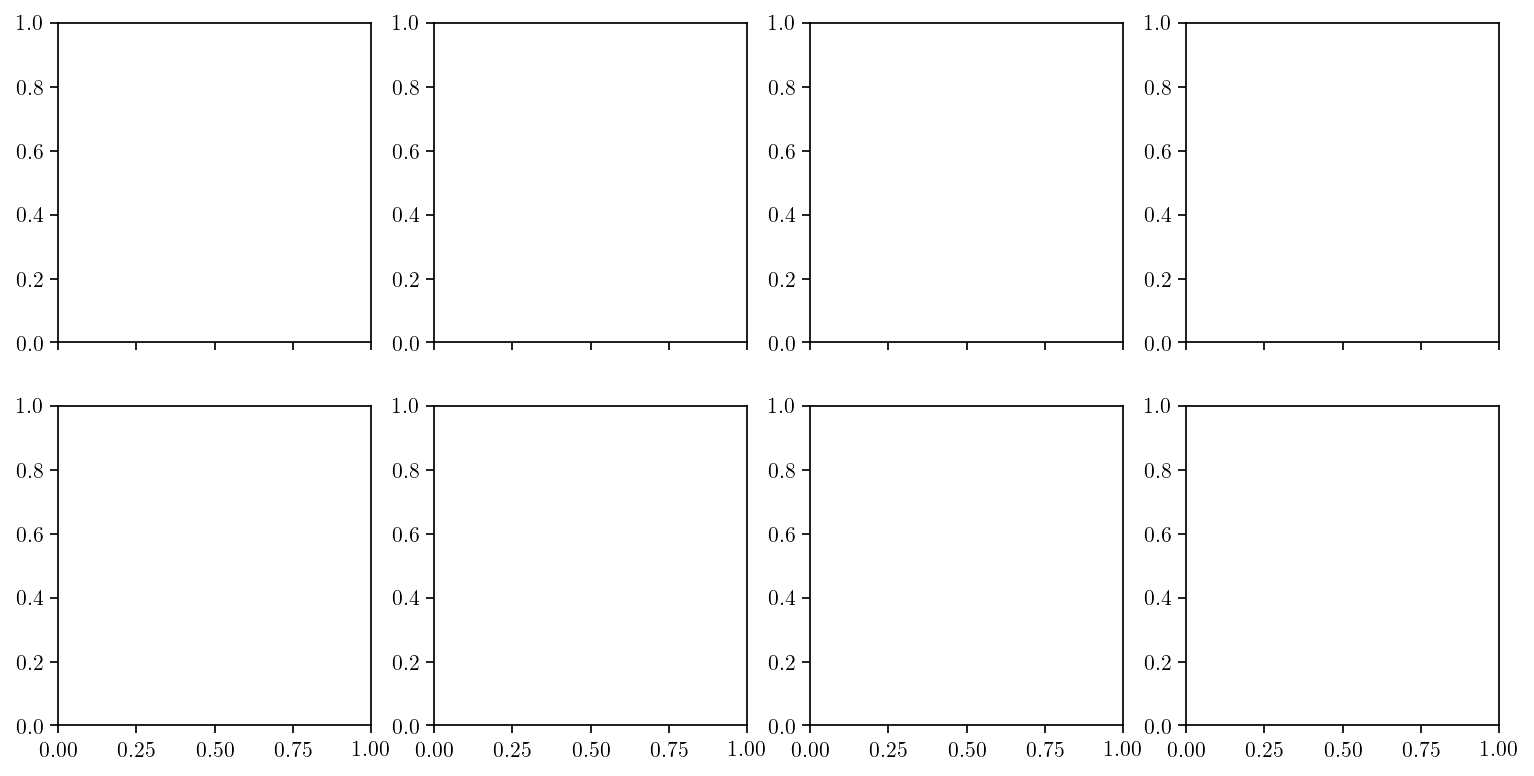

In [3]:
#initialize a normal distribution with frozen in mean=-1, std. dev.= 1
rv = norm(loc = 0., scale = 1.0)
rv1 = norm(loc = -3., scale = 1.0)
rv2 = norm(loc = 3., scale = 1.0)
x = np.arange(-10, 10, .001)

# plot the pdfs of these normal distributions 
#plt.plot(x, rv.pdf(x), x, norm_multi(x, [rv1, rv2]))
#plt.show()

print("------------ Sanity check start -------------")
print("Calculate KL divergence between uni-modal distributions.")
print("Numeric values should be somehow equal to the analytic values!")
# numeric
dkl_num_LvsM = entropy_sanity(pk = rv.pdf(x), qk = rv1.pdf(x))
dkl_num_RvsM = entropy_sanity(pk = rv.pdf(x), qk = rv2.pdf(x))
print("KLD left vs. middle (numeric): " + str(dkl_num_LvsM))
print("KLD right vs. middle (numeric): " + str(dkl_num_RvsM))
# analytic
print("KLD left vs. middle (analytic): " + str(dkl_gauss_opt([rv.mean(), rv.std()], mu1 = rv1.mean(), std1 = rv1.std())))
print("KLD right vs. middle (analytic): " + str(dkl_gauss_opt([rv.mean(), rv.std()], mu1 = rv1.mean(), std1 = rv2.std())))
print("------------ Sanity check end -------------")
print("")

print("A DK-minimization approach that samples either N_1 or N_2 will try to put the " +
    "resulting N into the middle of both distributions, because it does not see any relation" +
    "between these distributions. " +
    "This is because the KL defined on single Gaussian does only cover one Gaussian at a time," +
    "Therefore, it is obvious that the minimum resulting N has mu=0.5(mu_1 + mu_2) and " +
    "std = sqrt(std_1^2 + std_2^2)")
print("")

f, axs = plt.subplots(2,4, figsize=(12,6), dpi=155, sharex=True, sharey=False)
axs_flat = axs.flatten()

In [4]:
def KLD_eval(rv, rv1, rv2, plot = True, x = np.arange(-10, 10, .001), do_print=True):
    r_full = entropy_sanity(pk = rv.pdf(x), qk=norm_multi(x, [rv1, rv2]))
    r_naive = dkl_gauss_mog_sum([rv.mean(), rv.std()], [[rv1.mean(), rv1.std()],[rv2.mean(), rv2.std()]])
    r_full_q_is_p = entropy_sanity(pk = rv.pdf(x), qk=norm_multi(x, [rv1, rv2]), q_is_p=True)
    r_naive_q_is_p = dkl_gauss_mog_sum([rv.mean(), rv.std()], [[rv1.mean(), rv1.std()],[rv2.mean(), rv2.std()]], True)
    if do_print:
        print("mu_mid, mu_left, mu_right, std_mid, std_left, std_right: "
          + str(rv.mean()) + ", " + str(rv1.mean()) + ", " + str(rv2.mean()) + ", "
          + str(rv.std()) + ", " + str(rv1.std()) + ", " + str(rv2.std()))
        print("1. p:N vs. q:MoG (sum of single KLD, i.e. optimized by the NN): " + str(r_naive))
        print("2. p:N vs. q:MoG (numeric and corrent KLD between joint and middle PDF): " + str(r_full))
        print("3. p:MoG vs. q:N (sum of single KLD, i.e. optimized by the NN): " + str(r_naive_q_is_p))
        print("4. p:MoG vs. q:N (numeric and corrent KLD between joint and middle PDF): " + str(r_full_q_is_p))
        print("")
    #plot the pdfs of these normal distributions
    if plot:
        axs_flat[KLD_eval.axs_idx].plot(x, rv.pdf(x), x, norm_multi(x, [rv1, rv2]))
        axs_flat[KLD_eval.axs_idx].set_title("N(%.0f,%.0f)" %(rv.mean(), rv.std()))
        KLD_eval.axs_idx += 1
    KLD_eval.r_naive.append(r_naive)
    KLD_eval.r_full.append(r_full)
    KLD_eval.r_naive_q_is_p.append(r_naive_q_is_p)
    KLD_eval.r_full_q_is_p.append(r_full_q_is_p)
    return r_naive, r_full, r_naive_q_is_p, r_full_q_is_p
KLD_eval.axs_idx = int(0)
KLD_eval.r_naive, KLD_eval.r_full, KLD_eval.r_naive_q_is_p, KLD_eval.r_full_q_is_p = [], [], [], []

scale = [.5, 1., 2., 3., 4., 8., 12., 16.]
for s in scale:
    rv = norm(loc = 0., scale = s)
    KLD_eval(rv, rv1, rv2, do_print=False)
plt.tight_layout()
plt.show()

4.4999999999739675
4.5


## Effect on DKL by permutation of standard diviation between an MoG and univariate Gaussian

In [13]:
# Calculate all the dkls by varying the scale of the univariate Gaussian
rv1 = norm(loc = -3., scale = 1.0)
rv2 = norm(loc = 3., scale = 1.0)
x = np.arange(-10, 10, .001)
scale = np.concatenate((np.linspace(0.01, 4., 50,endpoint=False),np.linspace(4., 16., 36)))
KLD_eval.r_naive, KLD_eval.r_full, KLD_eval.r_naive_q_is_p, KLD_eval.r_full_q_is_p = [], [], [], []
for s in scale:
    rv = norm(loc = 0., scale = s)
    KLD_eval(rv, rv1, rv2, plot=False, do_print=False)

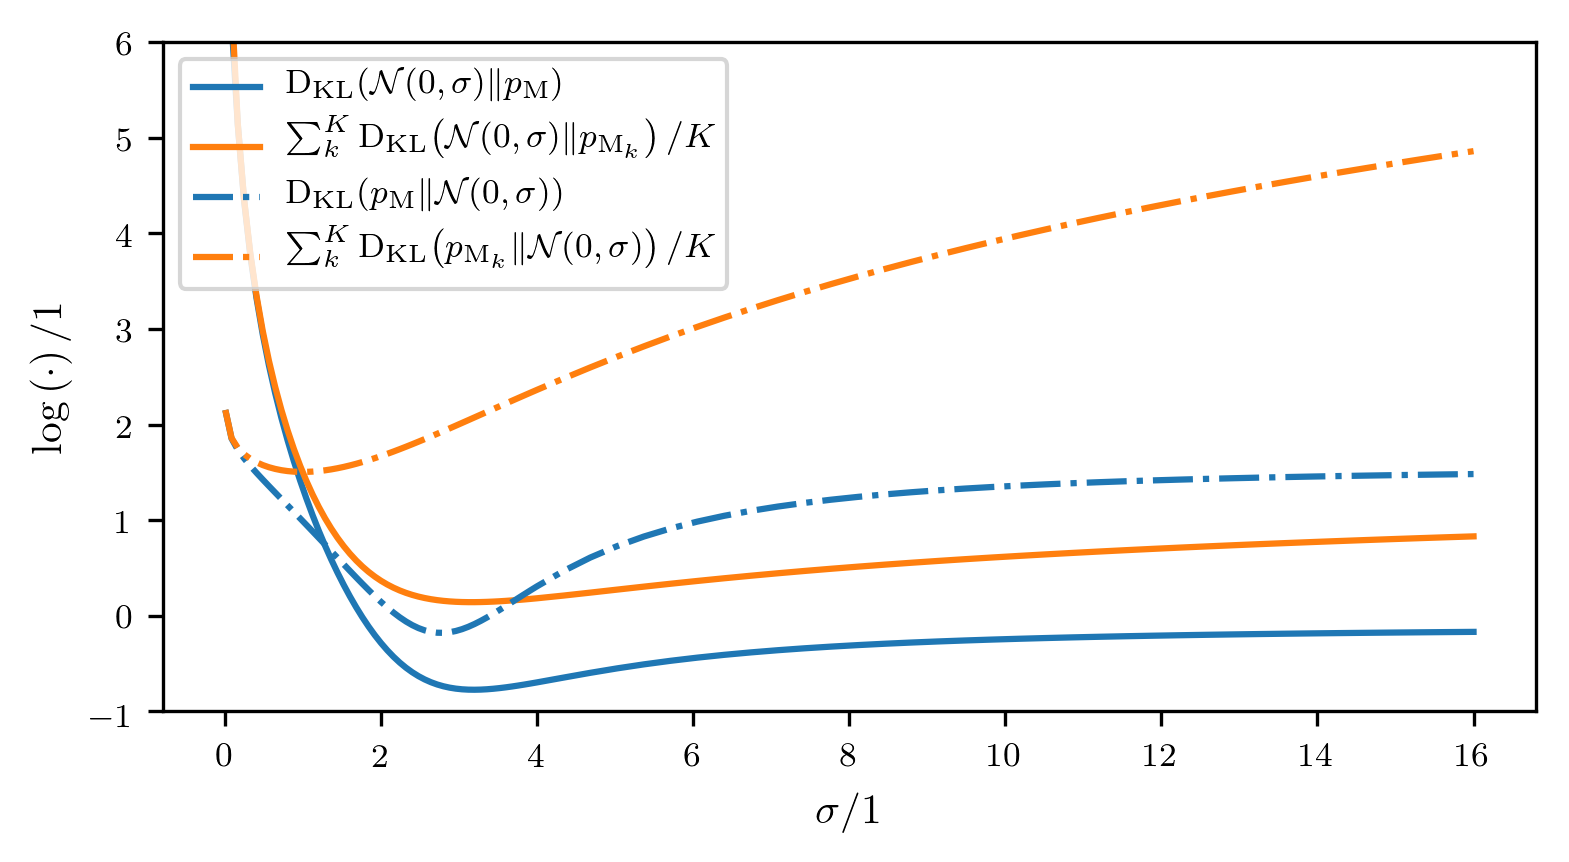

It can be seen, that both error functions (not metrics) are convex but at different points of the standard deviation. The KLD of the solid curves tends to have a minima at the same location, which is not true in general, as empirically shown in the later plots. Furthermore, the true DKL is always smaller than the sum over DKLs.


In [29]:
_, ax = plt.subplots(1,1,figsize=(paper_width_inch,paper_width_inch/2.), dpi=300)
#"exact. p:N"
ax.plot(scale, np.log(KLD_eval.r_full),label=r"$\text{D}_{\text{KL}}\!\left(\mathcal{N}(0,\sigma)\|p_{\text{M}}\right)$")
#"approx. p:N"
ax.plot(scale, np.log(KLD_eval.r_naive),label=r"$\sum_k^K\text{D}_{\text{KL}}\!\left(\mathcal{N}(0,\sigma)\|p_{\text{M}_k}\right)/K$")
plt.gca().set_prop_cycle(None) # reset color cycle
#"exact. p:MoG"
ax.plot(scale, np.log(KLD_eval.r_full_q_is_p),'-.',label=r"$\text{D}_{\text{KL}}\!\left(p_{\text{M}}\|\mathcal{N}(0,\sigma)\right)$")
#"approx. p:MoG"
ax.plot(scale, np.log(KLD_eval.r_naive_q_is_p),'-.',label=r"$\sum_k^K\text{D}_{\text{KL}}\!\left(p_{\text{M}_k}\|\mathcal{N}(0,\sigma)\right)/K$")
plt.legend(prop={'size': 8, 'family': 'serif'})
# plt.title("Effect on DKL by permutation of arguments between an MoG and univariate Gaussian", fontsize=10, fontfamily='serif')
plt.ylabel(r"$\log\left(\cdot\right) / 1$", fontsize=10, fontfamily='serif')
plt.xlabel(r"$\sigma / 1$", fontsize=10, fontfamily='serif')
plt.ylim([-1,6])
plt.gca().tick_params(axis='both', which='minor', labelsize=8) # , pad=-4, labelrotation=45)
plt.gca().tick_params(axis='both', which='major', labelsize=8) # , pad=-4, labelrotation=45)
plt.savefig("/tmp/kl_divergence_N_vs_MoG_over_sigma.pdf", dpi='figure', transparent=True, papertype='a4', bbox_inches='tight')
plt.show()

print("It can be seen, that both error functions (not metrics) are convex but" + 
      " at different points of the standard deviation. The KLD of the solid" + 
      " curves tends to have a minima at the same location, which is not true" +
      " in general, as empirically shown in the later plots." + 
      " Furthermore, the true DKL is always smaller than the sum over DKLs.")

In [34]:
k = 4
print(KLD_eval.r_full[k])
print(KLD_eval.r_naive[k])

43.836718448393455
44.52601638193715


In [8]:
a, b = 0.2, 0.5
print("Concave")
print("log(sum_k 1/k p): ", np.log((a+b)/2.))
print("sum_k 1/k log(p): ", np.log(a)/2. + np.log(b)/2.)
print(r"sum_k 1/k log(p) <= log(sum_k 1/k p)") 
print("Convex")
print("exp(sum_k 1/k p): ", np.exp((a+b)/2.))
print("sum_k 1/k exp(p): ", np.exp(a)/2. + np.exp(b)/2.)
print(r"sum_k 1/k exp(p) >= exp(sum_k 1/k p)") 

Concave
log(sum_k 1/k p):  -1.0498221244986778
sum_k 1/k log(p):  -1.1512925464970227
sum_k 1/k log(p) <= log(sum_k 1/k p)
Convex
exp(sum_k 1/k p):  1.4190675485932571
sum_k 1/k exp(p):  1.435062014430149
sum_k 1/k exp(p) >= exp(sum_k 1/k p)


In [21]:
# Sanity Check: Single Gaussian optimization

# Inital seed
mu_init = 1
std_init = 1.2
x0 = [mu_init, std_init]
# Target parameters
mu1 = 0.
std1 = 1.

xOpt = fmin(dkl_gauss_opt, x0, args=(mu1, std1, False, ))
print("Befor Optimization: " + str(dkl_gauss_opt(x0, mu1 = mu1, std1 = std1)))
print("After Optimization: " + str(dkl_gauss_opt(xOpt, mu1 = mu1, std1 = std1)))
print("mu: " + str(round(xOpt[0],2)) + ", std: " + str(round(xOpt[1],2)))

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 37
         Function evaluations: 73
Befor Optimization: 0.5376784432060453
After Optimization: 5.775406819452655e-10
mu: -0.0, std: 1.0


In [22]:
# Multi Gaussian optimization (as it would be done by NN)

# Inital seed
mu_init = 1
var_init = 1.2
x0 = [mu_init, var_init]
# Target parameters
mu1 = 1.
std1 = 1.
mu2 = -1.
std2 = 1.

#mu1 = 10.
#std1 = 1.
#mu2 = -10.
#std2 = 2.


xOpt = fmin(dkl_gauss_opt2, x0, args=(mu1, std1, mu2, std2, False, ))
print("Before Optimization: " + str(dkl_gauss_mog_sum(x0, [[mu1, std1], [mu2, std2]])))
print("After Optimization: " + str(dkl_gauss_mog_sum(xOpt, [[mu1, std1], [mu2, std2]])))
print("mu: " + str(round(xOpt[0],2)) + ", std: " + str(round(xOpt[1],2)))

Optimization terminated successfully.
         Current function value: 0.346574
         Iterations: 39
         Function evaluations: 77
Before Optimization: 0.7239882234606212
After Optimization: 0.34657359091072953
mu: 0.0, std: 1.41


In [9]:
# Mixture of Gaussian optimization

# Inital seed
mu_init = 1
var_init = 1.2
x0 = [mu_init, var_init]
# Target parameters
mu1 = 1.
var1 = 1.
mu2 = -1.
var2 = 1.

pdf_joint = norm_multi(x, [norm(loc = mu1, scale = std1), norm(loc = mu2, scale = std2)])
x = np.arange(-10, 10, .001)
xOpt = fmin(entropy_opt, x0, args=(pdf_joint, x, False, ))

# Print
rv = norm(loc = x0[0], scale = x0[1])
print("Befor Optimization: " + str(entropy_sanity(pk = rv.pdf(x), qk = pdf_joint)))
rv = norm(loc = xOpt[0], scale = xOpt[1])
print("After Optimization: " + str(entropy_sanity(pk = rv.pdf(x), qk = pdf_joint)))
print("mu: " + str(round(xOpt[0],2)) + ", std: " + str(round(xOpt[1],2)))

Optimization terminated successfully.
         Current function value: 0.010888
         Iterations: 39
         Function evaluations: 75
Befor Optimization: 0.27810299151520357
After Optimization: 0.010887864188974963
mu: -0.0, std: 1.39


In [6]:






















batch_size = 128
input_dim_dummy = 1 # const.
latent_dim_1 = 16
latent_dim_samp = 1
epochs = 50


def sampling(args):
    mu, std = args
    epsilon = K.random_normal(shape=(K.shape(mu)[0], latent_dim_samp), mean=0., stddev=1.)
    return mu + std * epsilon

def get_model():
    mean_target = Input(shape=(latent_dim_samp,), name="input_mean_target")
    std_target = Input(shape=(latent_dim_samp,), name="input_std_target")
    x = Input(shape=(input_dim_dummy,), name="input_dummy")
    h = Dense(latent_dim_1, activation='relu', name="latent1")(x)
    mean = Dense(latent_dim_samp, name="mean")(h)
    std = Dense(latent_dim_samp, activation='relu', name="std")(h)
    
    # note that "output_shape" isn't necessary with the TensorFlow backend
    sample        = Lambda(sampling, output_shape=(latent_dim_samp,), name="sample")([mean, std])
    sample_target = Lambda(sampling, output_shape=(latent_dim_samp,), name="sample_target")([mean_target, std_target])
    return sample, sample_target, mean_target, std_target, mean, std, x

# Custom loss layer with KL and MSE loss
class CustomVariationalReconstructLayer(Layer):
    def __init__(self, **kwargs):
        self.is_placeholder = True
        super(CustomVariationalReconstructLayer, self).__init__(**kwargs)

    def kl_loss(self, mu_1, std_1, mu_2, std_2):
        return K.sum(K.log(std_2) - K.log(std_1) + 
                     (K.square(std_1) + K.square(mu_1 - mu_2)) / (2*K.square(std_2)) -
                     1/2. , axis=-1)

    def kl_loss_n(self, mu_1, std_1):
        return K.sum( - K.log(std_1) + 
                     (K.square(std_1) + K.square(mu_1)) -
                     1/2. , axis=-1)
#    def kl_loss(self, mean_target, std_target, mean, std):
#        return K.sum(- .5 * (1  + K.log(std) - K.log(std_target) - (K.square(std) + K.square(mean - mean_target)) / (K.square(std_target))), axis=-1)

    def loss(self, sample, sample_target, mean_target, std_target, mean, std):
        #mse_loss = latent_dim_samp * metrics.mean_squared_error(sample, sample_target)
        mse_loss = 1 / (1+ K.abs(sample)) # try to learn an ambiguous variable (aka 0.) 
        return K.mean(mse_loss + self.kl_loss(mean_target, std_target, mean, std) + self.kl_loss_n(mean, std))

    def call(self, inputs):
        sample = inputs[0]
        sample_target = inputs[1]
        mean_target = inputs[2]
        std_target = inputs[3]
        mean = inputs[4]
        std = inputs[5]
        loss = self.loss(sample, sample_target, mean_target, std_target, mean, std)
        self.add_loss(loss, inputs=inputs)
        # We won't actually use the output.
        return sample

# Custom loss layer with KL loss only
class CustomVariationalLayer(CustomVariationalReconstructLayer):
    def __init__(self, **kwargs):
        super(CustomVariationalLayer, self).__init__(**kwargs)
        
    def loss(self, sample, sample_target, mean_target, std_target, mean, std):
        return K.mean(self.kl_loss(mean_target, std_target, mean, std))


In [7]:
# Define training data
num = 5000
mean_target_noise_std = 0.01
mean_targets_gt = np.array([-1., 1.])

std_target_noise_std = 0.01
std_targets_gt = np.array([.1, .1])

rv1 = norm(loc = mean_targets_gt[0], scale = std_targets_gt[0])
rv2 = norm(loc = mean_targets_gt[1], scale = std_targets_gt[1])

target_choice = np.random.choice(np.int32([0, 1]), size=(num,))
mean_targets_samples = mean_targets_gt[target_choice] + mean_target_noise_std * np.random.standard_normal(size=(num,))
std_target_samples = std_targets_gt[target_choice] + std_target_noise_std * (np.random.rand(num) - 0.5)
np.random.seed(0)
dummy = np.random.rand(num)
#dummy = np.ones((num,))
#dummy = np.zeros((num,))

In [8]:
tf.compat.v1.set_random_seed(3)
sample, sample_target, mean_target, std_target, mean, std, x = get_model()
y_kl = CustomVariationalLayer()([sample, sample_target, mean_target, std_target, mean, std])
model_kl = Model([mean_target, std_target, x], y_kl)
model_kl.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False), loss=None)

#SVG(model_to_dot(model_kl).create(prog='dot', format='svg'))

# train the model
model_kl.fit(x = [mean_targets_samples, std_target_samples, dummy],
            y = None,
            shuffle=True,
            epochs=epochs,
            batch_size=batch_size,
            verbose = 0)

In [9]:
estimation_kl = Model(x, [mean, std])
mean_estimated_kl, std_estimated_kl = estimation_kl.predict(np.array([0.5]))[0], estimation_kl.predict(np.array([0.5]))[1]
print("mean_estimated: " + str(mean_estimated_kl))
print("std_estimated: " + str(std_estimated_kl))
# SVG(model_to_dot(estimation).create(prog='dot', format='svg'))

rv = norm(loc = mean_estimated_kl[0,0], scale = std_estimated_kl[0,0])
KLD_eval(rv, rv1, rv2, plot = False)

print(dkl_gauss(rv.mean(), rv.std(), rv1.mean(), rv1.std()))
print(dkl_gauss(rv.mean(), rv.std(), rv1.mean(), rv1.std()))

print(dkl_gauss(0., .09, 1., .1))


mean_estimated: [[-0.01244881]]
std_estimated: [[0.63616794]]
mu_mid, mu_left, mu_right, std_mid, std_left, std_right: -0.012448806315660477, -1.0, 1.0, 0.6361679549988288, 0.1, 0.1
1. KLD joint vs. middle (sum of single KLD, i.e. optimized by the NN): 5.1965839657781
2. KLD joint vs. middle (numeric and corrent KLD between joint and middle PDF): 1.905144829422112

66.64805893306195
66.64805893306195
50.01036051565782


In [10]:
tf.compat.v1.set_random_seed(4)
sample, sample_target, mean_target, std_target, mean, std, x = get_model()
y_kle = CustomVariationalReconstructLayer()([sample, sample_target, mean_target, std_target, mean, std])
model_kle = Model([mean_target, std_target, x], y_kle)
model_kle.compile(optimizer='adam', loss=None)

# train the model
model_kle.fit(x = [mean_targets_samples, std_target_samples, dummy],
            y = None,
            shuffle=True,
            epochs=epochs,
            batch_size=batch_size,
            verbose = 0)

In [11]:
estimation_kle = Model(x, [mean, std])
mean_estimated_kle, std_estimated_kle = estimation_kle.predict(np.array([0.5]))[0], estimation_kle.predict(np.array([0.5]))[1]
print("mean_estimated: " + str(mean_estimated_kle))
print("std_estimated: " + str(std_estimated_kle))
# SVG(model_to_dot(estimation).create(prog='dot', format='svg'))

rv = norm(loc = mean_estimated_kle[0,0], scale = std_estimated_kle[0,0])
KLD_eval(rv, rv1, rv2, plot = False)

mean_estimated: [[-0.00516213]]
std_estimated: [[0.30025786]]
mu_mid, mu_left, mu_right, std_mid, std_left, std_right: -0.005162134766578674, -1.0, 1.0, 0.3002578590771592, 0.1, 0.1
1. KLD joint vs. middle (sum of single KLD, i.e. optimized by the NN): 12.402193863300958
2. KLD joint vs. middle (numeric and corrent KLD between joint and middle PDF): 5.50794966487683



(12.402193863300958, 5.50794966487683)

## Plot DKL of gaussian against uni-gaussian

In [8]:
# Prepare variables
# p
mean1 = 0
log_var1 = 0
# q 
mu_min = -4.
mu_max = 4.
sigma_min = .2
sigma_max = 3.
delta = 0.1

sigma =  list(np.linspace(sigma_min, sigma_max, int((sigma_max - sigma_min) / delta)))
mu = list(np.linspace(mu_min, mu_max, int((mu_max - mu_min) / delta)))

Sigma, Mu = np.meshgrid(sigma, mu)
dkl_orig = vae_tools.metrics.kl_loss(mean1, np.ravel(Mu), log_var1, 2.*np.log(np.ravel(Sigma)))
Dkl_orig = dkl_orig.reshape(Sigma.shape)
dkl_rev = vae_tools.metrics.kl_loss(np.ravel(Mu), mean1, 2.*np.log(np.ravel(Sigma)), log_var1)
Dkl_rev = dkl_rev.reshape(Sigma.shape)

JS = np.zeros(Sigma.shape)
with np.nditer(JS, op_flags=['readwrite']) as JS_iter:
    x = np.arange(-10, 10, .001)
    rv_1 = norm(loc = mean1, scale = (np.exp(log_var1/2.)))
    pk = rv_1.pdf(x)
    for s, m, j in zip(np.nditer(Sigma), np.nditer(Mu), JS_iter):
        rv_2 = norm(loc = m, scale = s)
        qk = rv_2.pdf(x)
        j[...] = js_sanity(pk, qk)
print("fin")

fin


/home/tkorthals/.local/lib/python3.5/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/home/tkorthals/.local/lib/python3.5/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


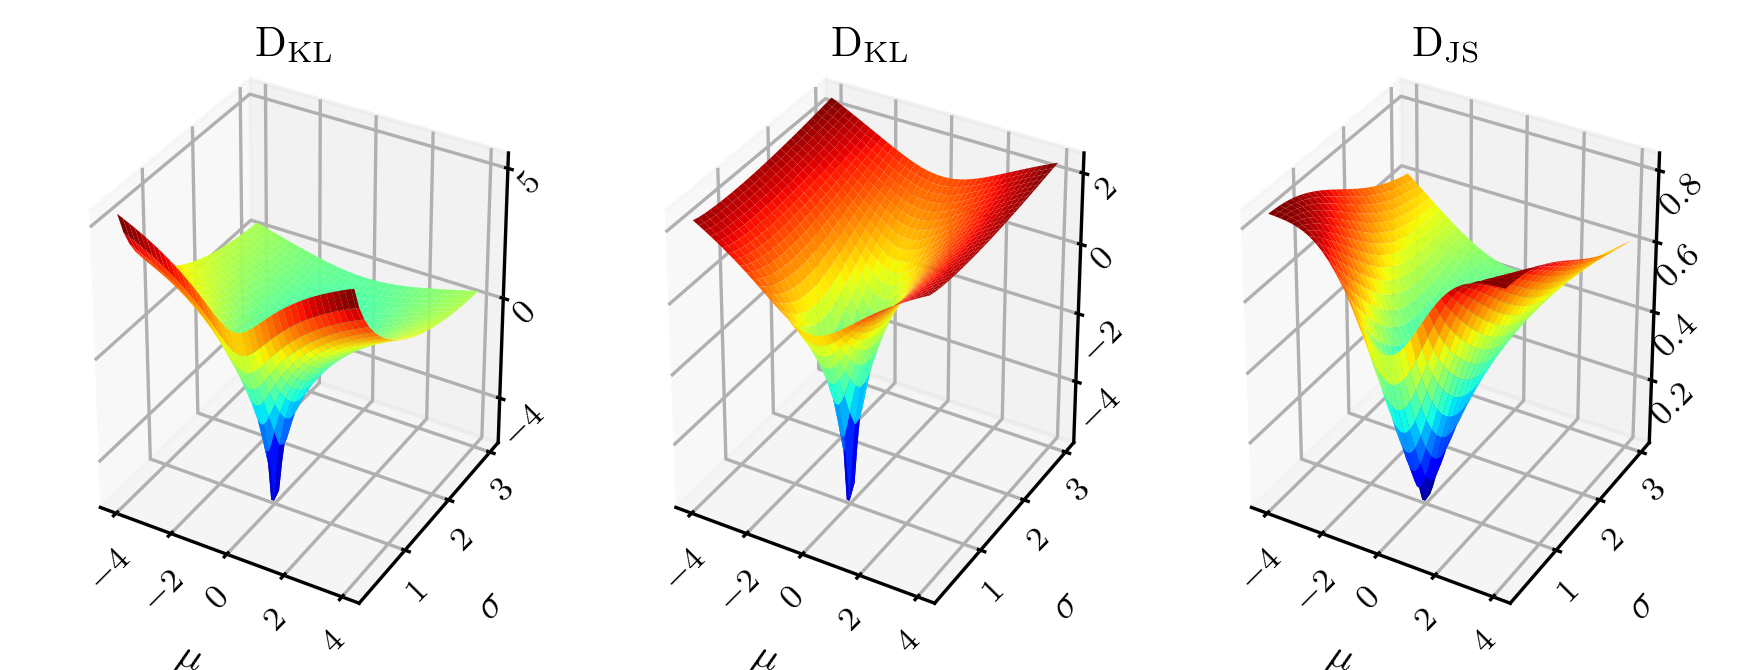

In [9]:
# Plot and save the figure

fig = plt.figure(figsize=(paper_width_inch,2), dpi=300)
axs = []
# ln(D_{KL}(\mathcal{N}(0,1)||q))
ax = fig.add_subplot(131, projection='3d')
ax.plot_surface(Mu, Sigma, np.log(Dkl_orig), cmap=cm.jet, linewidth=0.1)
ax.set_xlabel(r'$\mu$', fontsize=10, fontfamily='serif', labelpad=-5)
ax.set_ylabel(r'$\sigma$', fontsize=10, fontfamily='serif', labelpad=-5)
#ax.set_zlabel(r'$D_{\text{KL}}$', fontsize=10, fontfamily='serif', labelpad=-5)
#ax.set_title(r'$ln(D_{KL}(\mathcal{N}(0,1)||q))$', fontsize=10, fontfamily='serif')
ax.set_title(r'D\textsubscript{KL}', fontsize=10, fontfamily='serif')
ax.tick_params(axis='both', which='minor', labelsize=8, pad=-4, labelrotation=45)
ax.tick_params(axis='both', which='major', labelsize=8, pad=-4, labelrotation=45)
ax.set_zticks([-4, 0, 5])
axs.append(ax)
# ln(D_{KL}(p||\mathcal{N}(0,1))
ax = fig.add_subplot(132, projection='3d')
ax.plot_surface(Mu, Sigma, np.log(Dkl_rev), cmap=cm.jet, linewidth=0.1)
ax.set_xlabel(r'$\mu$', fontsize=10, fontfamily='serif', labelpad=-5)
ax.set_ylabel(r'$\sigma$', fontsize=10, fontfamily='serif', labelpad=-5)
#ax.set_zlabel(r'$D_{\text{KL}}$', fontsize=10, fontfamily='serif', labelpad=-5)
#ax.set_title(r'$ln(D_{KL}(p||\mathcal{N}(0,1)))$', fontsize=10, fontfamily='serif')
ax.set_title(r'D\textsubscript{KL}', fontsize=10, fontfamily='serif')
ax.tick_params(axis='both', which='minor', labelsize=8, pad=-4, labelrotation=45)
ax.tick_params(axis='both', which='major', labelsize=8, pad=-4, labelrotation=45)
axs.append(ax)
# ln(\mathcal{N}(0,1)||q) + D_{KL}(p||\mathcal{N}(0,1))
ax = fig.add_subplot(133, projection='3d')
#ax.plot_surface(Mu, Sigma, np.log(np.abs(Dkl_rev - Dkl_orig)), cmap=cm.jet, linewidth=0.1)
ax.plot_surface(Mu, Sigma, JS, cmap=cm.jet, linewidth=0.1)
ax.set_xlabel(r'$\mu$', fontsize=10, fontfamily='serif', labelpad=-5)
ax.set_ylabel(r'$\sigma$', fontsize=10, fontfamily='serif', labelpad=-5)
#ax.set_zlabel(r'$D_{\text{KL}}$', fontsize=10, fontfamily='serif', labelpad=-5)
#ax.set_title(r'$ln(D_{KL}^{left} + D_{KL}^{mid})$', fontsize=10, fontfamily='serif')
ax.set_title(r'D\textsubscript{JS}', fontsize=10, fontfamily='serif')
ax.tick_params(axis='both', which='minor', labelsize=8, pad=-4, labelrotation=45)
ax.tick_params(axis='both', which='major', labelsize=8, pad=-4, labelrotation=45)
axs.append(ax)
#
plt.tight_layout()
# Adjust the box.height, because a too small value cuts off the labels 
for ax in axs:
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width, 1.])
plt.savefig("/tmp/kl_divergence_error_surface_assymetry.pdf", dpi='figure', transparent=True, papertype='a4', bbox_inches='tight')
plt.show()

## Plot DKL of gaussian against MoG

Various cases of Gaussians vs. Mixture of Gaussians (MoG)

$$p_{\mathcal{N}_k}=\mathcal{N}(\mu_k, \sigma_k)$$
and
$$p_{\text{MoG}}=\frac{1}{2}p_{\mathcal{N}_1}+\frac{1}{2}p_{\mathcal{N}_2}\text{ with } \mu_1 = -\mu_2, \sigma_1 = \sigma_2$$

### Optimizing analytically

\begin{align}
\DeclareMathOperator\dkl{D_{KL}}
\dkl(p_{\mathcal{N}}\|p_{\text{MoG}}) \text{ with fixed } p_{\mathcal{N}}\\
\dkl(p_{\mathcal{N}}\|p_{\text{MoG}}) \text{ with fixed } p_{\text{MoG}}\\
\dkl(p_{\text{MoG}}\|p_{\mathcal{N}}) \text{ with fixed } p_{\mathcal{N}}\\
\dkl(p_{\text{MoG}}\|p_{\mathcal{N}}) \text{ with fixed } p_{\text{MoG}}
\end{align}

### Optimizing VAE style


\begin{align}
\DeclareMathOperator\dkl{D_{KL}}
\dkl(p_{\mathcal{N}}\|p_{\mathcal{N}_1})+\dkl(p_{\mathcal{N}}\|p_{\mathcal{N}_2}) \text{ with fixed } p_{\mathcal{N}}\\
\dkl(p_{\mathcal{N}}\|p_{\mathcal{N}_1})+\dkl(p_{\mathcal{N}}\|p_{\mathcal{N}_2}) \text{ with fixed } p_{\text{MoG}}\\
\dkl(p_{\mathcal{N}_1}\|p_{\mathcal{N}})+\dkl(p_{\mathcal{N}_2}\|p_{\mathcal{N}}) \text{ with fixed } p_{\mathcal{N}}\\
\dkl(p_{\mathcal{N}_1}\|p_{\mathcal{N}})+\dkl(p_{\mathcal{N}_2}\|p_{\mathcal{N}}) \text{ with fixed } p_{\text{MoG}}
\end{align}

### Test


# DKL: MoG vs Gaussian

In [4]:
# Functions for plotting
def calc_dkl_naive_plot(qk1_mu_std, qk2_mu_std, q_is_p = False):
    Dkl = np.zeros(Sigma.shape)
    with np.nditer(Dkl, op_flags=['readwrite']) as Dkl_iter:
        for sigma, mu, dkl in zip(np.nditer(Sigma), np.nditer(Mu), Dkl_iter):
            dkl[...] = dkl_gauss_mog_sum([mu, sigma], [qk1_mu_std, qk2_mu_std], q_is_p)
    return Dkl

def calc_dkl_plot(pk, q_is_p = False):
    Dkl = np.zeros(Sigma.shape)
    with np.nditer(Dkl, op_flags=['readwrite']) as Dkl_iter:
        for sigma, mu, dkl in zip(np.nditer(Sigma), np.nditer(Mu), Dkl_iter):
            qk = norm(loc = mu, scale = sigma).pdf(x)
            if q_is_p:
                dkl[...] = entropy_sanity(qk, pk)
            else:
                dkl[...] = entropy_sanity(pk, qk)
    return Dkl

In [7]:
# Prepare range of uni-modal Gaussian
mu_min = -4.
mu_max = 4.
sigma_min = .2
sigma_max = 3.
delta = 0.1
sigma =  list(np.linspace(sigma_min, sigma_max, int((sigma_max - sigma_min) / delta)))
mu = list(np.linspace(mu_min, mu_max, int((mu_max - mu_min) / delta)))
Sigma, Mu = np.meshgrid(sigma, mu)


# Prepare MoG (rv1, rv2) and DKL
scale = .3
rv1 = norm(loc = -2., scale = scale)
rv2 = norm(loc = 2., scale = scale)
x = np.arange(-10, 10, .001)
Dkl_2 = calc_dkl_plot(norm_multi(x, [rv1, rv2]))
Dkl_2_q_is_p = calc_dkl_plot(norm_multi(x, [rv1, rv2]), q_is_p = True)
Dkl_naive_2 = calc_dkl_naive_plot([rv1.mean(), rv1.std()], [rv2.mean(), rv2.std()])
Dkl_naive_2_q_is_p = calc_dkl_naive_plot([rv1.mean(), rv1.std()], [rv2.mean(), rv2.std()], q_is_p = True)

rv1 = norm(loc = -1., scale = scale)
rv2 = norm(loc = 1., scale = scale)
Dkl_1 = calc_dkl_plot(norm_multi(x, [rv1, rv2]))
Dkl_1_q_is_p = calc_dkl_plot(norm_multi(x, [rv1, rv2]), q_is_p = True)
Dkl_naive_1 = calc_dkl_naive_plot([rv1.mean(), rv1.std()], [rv2.mean(), rv2.std()])
Dkl_naive_1_q_is_p = calc_dkl_naive_plot([rv1.mean(), rv1.std()], [rv2.mean(), rv2.std()], q_is_p = True)

rv1 = norm(loc = -.5, scale = scale)
rv2 = norm(loc = .5, scale = scale)
Dkl_05 = calc_dkl_plot(norm_multi(x, [rv1, rv2]))
Dkl_05_q_is_p = calc_dkl_plot(norm_multi(x, [rv1, rv2]), q_is_p = True)
Dkl_naive_05 = calc_dkl_naive_plot([rv1.mean(), rv1.std()], [rv2.mean(), rv2.std()])
Dkl_naive_05_q_is_p = calc_dkl_naive_plot([rv1.mean(), rv1.std()], [rv2.mean(), rv2.std()], q_is_p = True)


## p: MoG vs q: Gaussian

Text(0.5, 0, 'log Dkl naive .5')

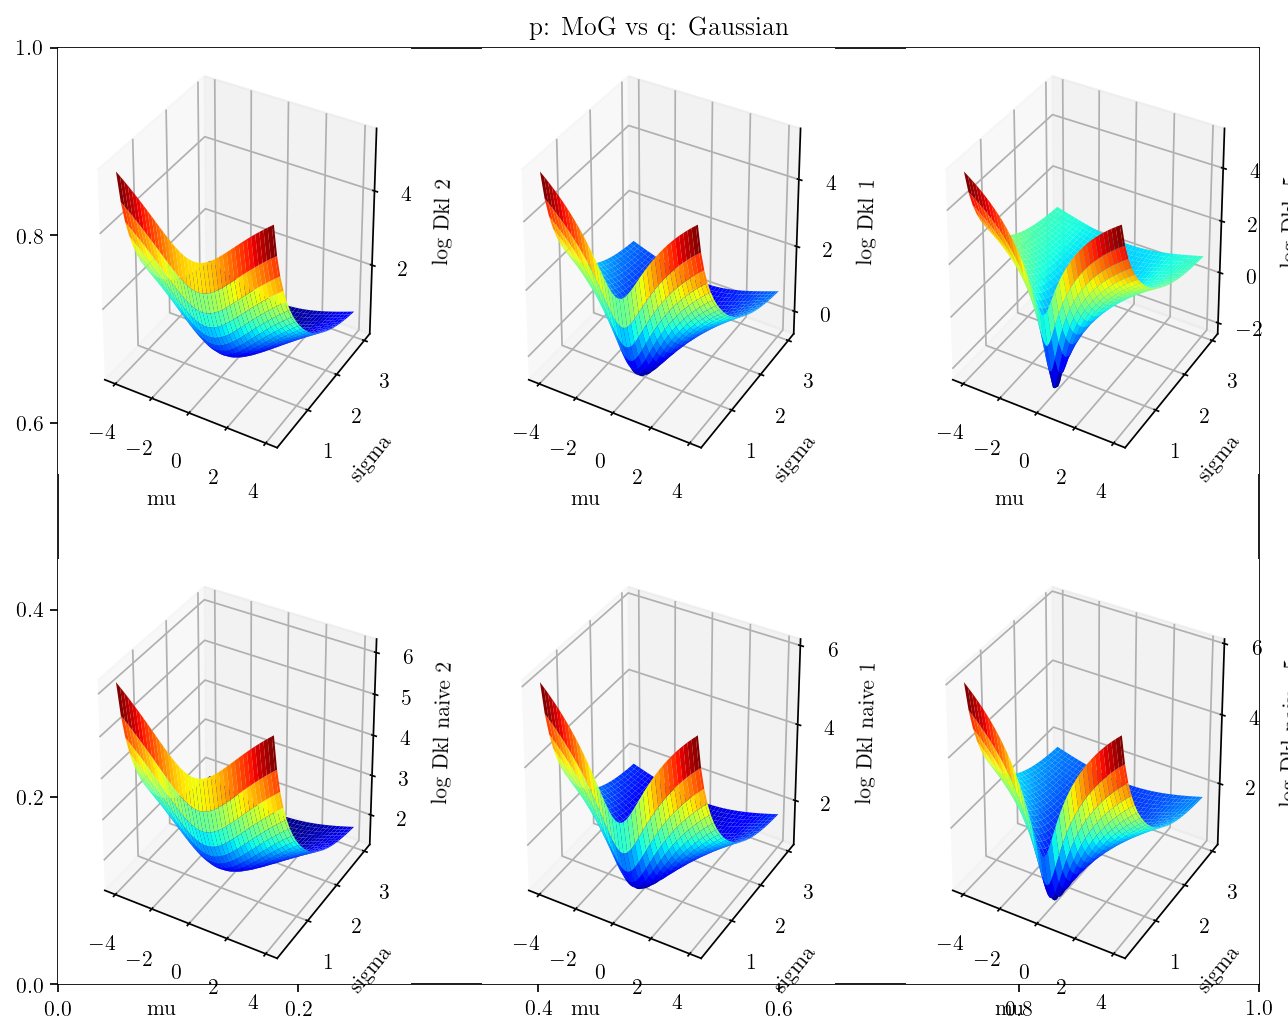

In [8]:
from mpl_toolkits.mplot3d import Axes3D  
# Axes3D import has side effects, it enables using projection='3d' in add_subplot
import matplotlib.pyplot as plt
from matplotlib import cm
fig = plt.figure(figsize=(10,8), dpi=155)
plt.title("p: MoG vs q: Gaussian")
ax = fig.add_subplot(231, projection='3d')
ax.plot_surface(Mu, Sigma, np.log(Dkl_2), cmap=cm.jet, linewidth=0.1)
ax.set_xlabel('mu')
ax.set_ylabel('sigma')
ax.set_zlabel('log Dkl 2')
ax = fig.add_subplot(232, projection='3d')
ax.plot_surface(Mu, Sigma, np.log(Dkl_1), cmap=cm.jet, linewidth=0.1)
ax.set_xlabel('mu')
ax.set_ylabel('sigma')
ax.set_zlabel('log Dkl 1')
ax = fig.add_subplot(233, projection='3d')
ax.plot_surface(Mu, Sigma, np.log(Dkl_05), cmap=cm.jet, linewidth=0.1)
ax.set_xlabel('mu')
ax.set_ylabel('sigma')
ax.set_zlabel('log Dkl .5')


ax = fig.add_subplot(234, projection='3d')
ax.plot_surface(Mu, Sigma, np.log(Dkl_naive_2), cmap=cm.jet, linewidth=0.1)
ax.set_xlabel(r'mu')
ax.set_ylabel(r'sigma')
ax.set_zlabel(r'log Dkl naive 2')
ax = fig.add_subplot(235, projection='3d')
ax.plot_surface(Mu, Sigma, np.log(Dkl_naive_1), cmap=cm.jet, linewidth=0.1)
ax.set_xlabel(r'mu')
ax.set_ylabel(r'sigma')
ax.set_zlabel(r'log Dkl naive 1')
ax = fig.add_subplot(236, projection='3d')
ax.plot_surface(Mu, Sigma, np.log(Dkl_naive_05), cmap=cm.jet, linewidth=0.1)
ax.set_xlabel(r'mu')
ax.set_ylabel(r'sigma')
ax.set_zlabel(r'log Dkl naive .5')

## p: Gaussian vs q: MoG

Text(0.5, 0, 'log Dkl naive .5 q is p')

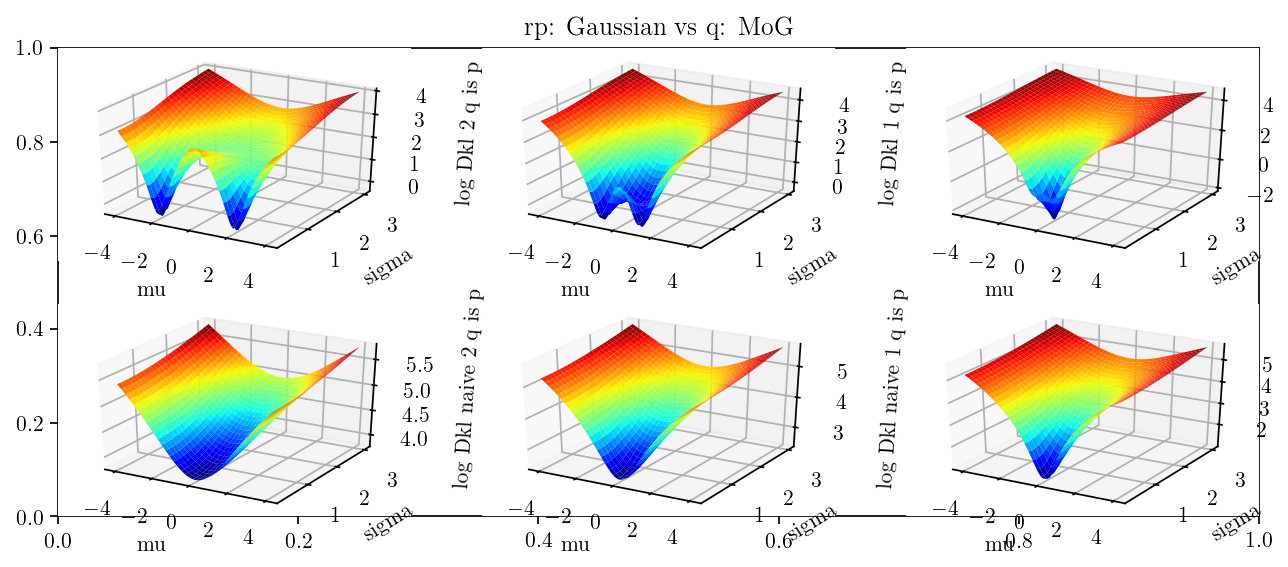

In [11]:
from mpl_toolkits.mplot3d import Axes3D  
# Axes3D import has side effects, it enables using projection='3d' in add_subplot
import matplotlib.pyplot as plt
from matplotlib import cm
fig = plt.figure(figsize=(10,4), dpi=155)
plt.title(r"rp: Gaussian vs q: MoG")
ax = fig.add_subplot(231, projection='3d')
ax.plot_surface(Mu, Sigma, np.log(Dkl_2_q_is_p), cmap=cm.jet, linewidth=0.1)
ax.set_xlabel(r'mu')
ax.set_ylabel(r'sigma')
ax.set_zlabel(r'log Dkl 2 q is p')
ax = fig.add_subplot(232, projection='3d')
ax.plot_surface(Mu, Sigma, np.log(Dkl_1_q_is_p), cmap=cm.jet, linewidth=0.1)
ax.set_xlabel(r'mu')
ax.set_ylabel(r'sigma')
ax.set_zlabel(r'log Dkl 1 q is p')
ax = fig.add_subplot(233, projection='3d')
ax.plot_surface(Mu, Sigma, np.log(Dkl_05_q_is_p), cmap=cm.jet, linewidth=0.1)
ax.set_xlabel(r'mu')
ax.set_ylabel(r'sigma')
ax.set_zlabel(r'log Dkl 05 q is p')


ax = fig.add_subplot(234, projection='3d')
ax.plot_surface(Mu, Sigma, np.log(Dkl_naive_2_q_is_p), cmap=cm.jet, linewidth=0.1)
ax.set_xlabel(r'mu')
ax.set_ylabel(r'sigma')
ax.set_zlabel(r'log Dkl naive 2 q is p')
ax = fig.add_subplot(235, projection='3d')
ax.plot_surface(Mu, Sigma, np.log(Dkl_naive_1_q_is_p), cmap=cm.jet, linewidth=0.1)
ax.set_xlabel(r'mu')
ax.set_ylabel(r'sigma')
ax.set_zlabel(r'log Dkl naive 1 q is p')
ax = fig.add_subplot(236, projection='3d')
ax.plot_surface(Mu, Sigma, np.log(Dkl_naive_05_q_is_p), cmap=cm.jet, linewidth=0.1)
ax.set_xlabel(r'mu')
ax.set_ylabel(r'sigma')
ax.set_zlabel(r'log Dkl naive .5 q is p')

In [12]:
def print_mu_std(mat, prefix = ""):
    idx = mat.argmin()
    print("%s mu: %.2f sigma: %.2f" %(prefix, Mu.flatten()[idx], Sigma.flatten()[idx]))

print_mu_std(Dkl_2)
print_mu_std(Dkl_1)
print_mu_std(Dkl_05)
print_mu_std(Dkl_naive_2)
print_mu_std(Dkl_naive_1)
print_mu_std(Dkl_naive_05)
print("")
print_mu_std(Dkl_2_q_is_p)
print_mu_std(Dkl_1_q_is_p)
print_mu_std(Dkl_05_q_is_p)
print_mu_std(Dkl_naive_2_q_is_p)
print_mu_std(Dkl_naive_1_q_is_p)
print_mu_std(Dkl_naive_05_q_is_p)

 mu: 0.05 sigma: 2.03
 mu: -0.05 sigma: 1.06
 mu: -0.05 sigma: 0.63
 mu: -0.05 sigma: 2.03
 mu: -0.05 sigma: 1.06
 mu: -0.05 sigma: 0.63

 mu: 1.97 sigma: 0.31
 mu: -0.96 sigma: 0.31
 mu: -0.05 sigma: 0.52
 mu: -0.05 sigma: 0.31
 mu: -0.05 sigma: 0.31
 mu: -0.05 sigma: 0.31
